<a href="https://colab.research.google.com/github/fabnancyuhp/DEEP-LEARNING/blob/main/NOTEBOOKS/Text_Mining_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook, we solve some text mining problem with Convolutional Neural Networks. In the context of text mining CNN are made of the following layers:
* conv1 Convolutional Layer
* pool1 Pooling Layer
* Embedding
* Dense : Fully Connected Layer

# Sentiments prediction of movie reviews with a CNN
In this case, we use a CNN to learn and predict whether a movie review is positive or negative. We first import the dataset in the cell below

In [1]:
#IMBD.to_pickle("./IMBD.pkl",compression='bz2')
import pandas as pd
#file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/IMDB.pkl"
file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/IMBD.parquet"
#IMDB = pd.read_pickle(file,compression='bz2')
IMDB = pd.read_parquet(file)
IMDB.head(4)

,review,sentiment
36191,If you like stupid jokes and a terribly predic...,negative
28616,Three young movie theater employees are given ...,negative
18130,The best bond game made of all systems. It was...,positive
29373,Nicolas Roeg ? He directed the classic superna...,negative


In [ ]:
!python --version

Python 3.7.12


We randomly choose a review and display it.

In [2]:
import numpy as np
np.random.randint(0,IMDB.shape[0])
IMDB.iloc[np.random.randint(0,IMDB.shape[0]),:].values

array(["Yep, lots of shouting, screaming, cheering, arguing, celebrating, fist clinching, high fiving & fighting. You have a general idea as to why, but can never be 100% certain. A naval knowledge would be an advantage for the finer points, but then you'd probably spot the many flaws. Not an awful film & Hackman & Washington are their usual brilliant, but the plot was one you could peg pretty early on. I'm still waiting to see a submarine film where people get on with each other & don't argue, but then you probably wouldn't have a film.<br /><br />4/10",
       'negative'], dtype=object)

## Fisrt step : texts preprocessing
We clean the reviews texts :
* We remove punctuations
* we remove html tags and URL tags
* we remove Emojis

In this case we decided to clean the texts, but, it is not necessarily a good idea to do such a thing. After cleaning the texts, we lower case the texts.

In [3]:
import re
def clean_text(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    return data

In [4]:
IMDB['review'] = IMDB['review'].apply(lambda x:clean_text(x).lower())

## Step 2: Encoding target values
We use the LabelEncoder from sklearn to encode the sentiment column. We store the encoding in a new column called encoded_target. There are only 2 values in the sentiment column positive and negative.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(IMDB['sentiment'].unique())

IMDB['encoded_target'] = IMDB['sentiment'] = le.transform(IMDB['sentiment'])

## Step 3 : Vectorizing the texts
In this step, we vectorize the text. We Tokenize IMDB['review'] using TensorFlow.keras. We store the result in X. We also compute the vocabulary size of the tokenization.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

X_token = [d.split() for d in list(IMDB['review'])]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_token)
X = tokenizer.texts_to_sequences(X_token)

vocab_size = len(tokenizer.word_index)+1

We study the length of text data. We draw a histogram of the size (count of words) of the reviews.

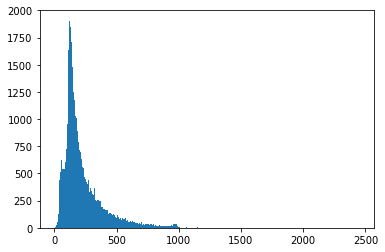

In [7]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X],bins=400)
plt.show()

Most of the texts are less than 300 words long. Then, we truncate all texts which have more than 300 words using pad_sequences. After we run the cell below, all texts are modelized in  300 components vectors.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_lenght = 300

X_pad = pad_sequences(X,maxlen=300,padding='post')
X_pad

array([[  44,   21,   36, ...,    0,    0,    0],
       [ 280,  182,   16, ...,    0,    0,    0],
       [   1,  115, 1371, ...,    0,    0,    0],
       ...,
       [   1, 9306,    4, ...,   53,  121, 5918],
       [  10,   18,    6, ...,    0,    0,    0],
       [   9,  549,   63, ...,    0,    0,    0]], dtype=int32)

## Splitting the dataset into a training set and a test set
We use the train_test_split method to make a training set and a test set.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad,IMDB['encoded_target'].values,test_size=0.20, random_state=42)

## Building the CNN with tensorflow.keras
We want to predict the fake newsWe build a model with the following layers:
* an Embedding layer with input_dim=len(tokenizer.word_index)+1, input_length=300. Since we want the dimension of the dense embedding is 100, we have to set output_dim=100.
* a Conv1D layer with 128 filters and kernel_size=5
* a GlobalMaxPooling1D() layer
* a Dense layer with 10 units and relu activation
* a Dense layer. Since we have only 2 classes (positive,negative), in the last dense layer we choose the sigmoid activation function.

We compile this model with an adam optimizer, a binary_crossentropy loss function and the accuracy metric. After,We fit the model.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

embedding_dim = 100
vocab_size = vocab_size = len(tokenizer.word_index)+1
#max_lenght = 300

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim= vocab_size, output_dim=embedding_dim, input_length=max_lenght))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          20782100  
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,847,529
Trainable params: 20,847,529
Non-trainable params: 0
____________________________________________

Here, we fit the model with 10 epochs and use 10% of the train set as a validation set.

In [13]:
history = model_cnn.fit(X_train, y_train,epochs=5,validation_split=0.1)

Epoch 1/5
1013/1013 [==============================] - 24s 15ms/step - loss: 0.3670 - accuracy: 0.8285 - val_loss: 0.2627 - val_accuracy: 0.8928
Epoch 2/5
1013/1013 [==============================] - 16s 16ms/step - loss: 0.1261 - accuracy: 0.9561 - val_loss: 0.2427 - val_accuracy: 0.9097
Epoch 3/5
1013/1013 [==============================] - 15s 15ms/step - loss: 0.0187 - accuracy: 0.9965 - val_loss: 0.2896 - val_accuracy: 0.9033
Epoch 4/5
1013/1013 [==============================] - 15s 15ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.3230 - val_accuracy: 0.9056
Epoch 5/5
1013/1013 [==============================] - 16s 15ms/step - loss: 3.3634e-04 - accuracy: 1.0000 - val_loss: 0.3391 - val_accuracy: 0.9083


We evaluate the model over the test set.

In [14]:
model_cnn.evaluate(X_test,y_test)

282/282 [==============================] - 1s 3ms/step - loss: 0.3580 - accuracy: 0.8981


[0.35795971751213074, 0.89811110496521]

## Trying the model on a new text
In this section, we try the model we've just fit in the previous section on a new text. 
* First, we preprocess the text as we did at the beginning of this example.
* Second step, we vectorize with the tokenizer we use earlier in this example and the pad_sequence object

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


new_text = "An absoloutely wonderful film that works on several levels. \
It's a story about a great architect, a son seeking his father, \
about very loving relationships, and about loss. It's also a great \
flm about architecture.<br /><br />Very intelligent and very moving. A real treat."

def handle_text(text):
    text_handle = clean_text(text)
    text_handle = [text_handle.split()]
    text_handle = tokenizer.texts_to_sequences(text_handle)
    text_handle = pad_sequences(text_handle,maxlen=300,padding='post')
    return(text_handle)
    
new_text_preprocessed = handle_text(new_text)

Now, we use the cnn_model to make a prediction. Then, we use the le.inverse_transform to layout the class of this new text.

In [16]:
proba_of_one = model_cnn.predict(new_text_preprocessed)[0][0]
if proba_of_one>0.5:
  print(le.inverse_transform([1]))
else:
  print(le.inverse_transform([0]))


1/1 [==============================] - 0s 96ms/step
['positive']


## Designing a more complex CNN
Here, we design a CNN with several convolutional layers  and several pooling layers. The last pooling layer yields a tensor with a (None, 37, 512) shape . As a consequence, After the last pooling layer we have to put a flatten layer to make the tensor adapted to a dense layer.  

In [17]:
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential


embedding_dim = 100
vocab_size = len(tokenizer.word_index)+1

CNN_COMPLEX = Sequential()
CNN_COMPLEX.add(Embedding(input_dim= vocab_size, output_dim=embedding_dim, input_length=max_lenght))
CNN_COMPLEX.add(Conv1D(128, 7, activation='relu',padding='same'))
CNN_COMPLEX.add(MaxPooling1D())
CNN_COMPLEX.add(Conv1D(256, 5, activation='relu',padding='same'))
CNN_COMPLEX.add(MaxPooling1D())
CNN_COMPLEX.add(Conv1D(512, 3, activation='relu',padding='same'))
CNN_COMPLEX.add(MaxPooling1D())
CNN_COMPLEX.add(Flatten())
CNN_COMPLEX.add(Dense(128, activation='relu'))
CNN_COMPLEX.add(Dropout(0.5))
CNN_COMPLEX.add(Dense(1, activation='sigmoid'))


CNN_COMPLEX.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
CNN_COMPLEX.fit(X_train, y_train,epochs=5,validation_split=0.1)

Epoch 1/5
1013/1013 [==============================] - 22s 21ms/step - loss: 0.3598 - accuracy: 0.8280 - val_loss: 0.2579 - val_accuracy: 0.8994
Epoch 2/5
1013/1013 [==============================] - 21s 21ms/step - loss: 0.1224 - accuracy: 0.9574 - val_loss: 0.2889 - val_accuracy: 0.9000
Epoch 3/5
1013/1013 [==============================] - 21s 21ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.5624 - val_accuracy: 0.8767
Epoch 4/5
1013/1013 [==============================] - 21s 21ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.4986 - val_accuracy: 0.8850
Epoch 5/5
1013/1013 [==============================] - 21s 21ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.6161 - val_accuracy: 0.8867


In [19]:
CNN_COMPLEX.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          20782100  
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          89728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 256)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 75, 512)          

# Exercice : reviews of fine foods
The dataset here consists of reviews of fine foods from amazon. We want to predict how does a customer feel about a product ordered from amazon using the review he made about the product.<br>
Run the cell below to import the dataset. There are three columns in that dataset : 
* Score is a rating between 1 and 5 of the product
* Summary are short reviews of the products
* Text are reviews of the products

Our goal is to predict the Score from the Summary and the Text.

In [20]:
import pandas as pd
#file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/fodd_review.pkl"
file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/food_reviews.parquet"
food_reviews = pd.read_parquet(file)
food_reviews.head(3)

,index,Score,Summary,Text
0,18588,5,Great at any strength,"This is not my favorite Peet's coffee blend, b..."
1,18638,5,Nearly Miraculous,"I don't usually bother with reviews, but these..."
2,509912,5,Great flavor combinations,"Great, healthy snack. The combination of frui..."


1/ How many distinct values are there in the Score column?

2/ Concat the column Summary and the column Text. Store the result in new column called whole_text.

In [ ]:
food_reviews['whole_text'] = 

3/ Clean food_reviews['whole_text'] column using the clean_text function we defined in the text preprocessing step of the IMDB example.  

In [ ]:
food_reviews['whole_text'] = 

4/ Vectorizing the texts from food_reviews['whole_text'] as we did in the Step 3 (Vectorizing the texts) from the previous example. You have to apply a Tokenizer object and a pad_sequences object. Store the result in X.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

X_token = [d.split() for d in list(food_reviews['whole_text'])]
tokenizer = Tokenizer()


#vocab_size = len(tokenizer.word_index)+1

We can choose a lot of values for the maxlen parameter of the pad_sequences object. We choose maxlen=150 and padding='post'.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_lenght = 150

X = 

5/  Use labelencoder from sklearn to encode food_reviews['Score']. Store the result in Y.

In [ ]:
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

le = LabelEncoder()

#Y = 

6/ Split X and Y in a training set and a test set. The vectorization X was made in question 4 and Y was made in question 5.

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.33, random_state=42)

7/The goal of this question is to retake the CNN we built in the section Building the CNN with tensorflow.keras and make few changes on it:
* you have to change a bit the last dense layer
* you have to compile your neural network with a different loss function

Fit the model with 5 epochs and validation_split=0.1.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

embedding_dim = 100
vocab_size = len(tokenizer.word_index)+1

8/ Evaluate your model over the test set.

9/ Try the model you built in the previous question on the text in the above cell. You have to use handle_food_revi to preprocess the new text.

In [ ]:
new_text = "Dogs love them, My dogs love these!  They get extremely excited\
when they know they're about to get one.  Two of the three dogs we have are\
four years old and their teeth are really clean.  My older six year old still\
has some buildup but these do help her go a little longer between cleanings."

from tensorflow.keras.preprocessing.sequence import pad_sequences

def handle_food_review(text):
    text_handle = clean_text(text)
    text_handle = [text_handle.split()]
    text_handle = tokenizer.texts_to_sequences(text_handle)
    text_handle = pad_sequences(text_handle,maxlen=150,padding='post')
    return(text_handle)

#handle_food_review(new_text)

10/ Build a CNN with the following layers:
* an Embedding layer with output_dim=100
* a Dropout with rate = 0.1
* a SeparableConv1D with 70 filters, kernel_size of 5, a relu activation and padding='same'
* a SeparableConv1D with 70 filters, kernel_size of 5, a relu activation and padding='same'
* MaxPooling1D()
* a SeparableConv1D with 140 filters, kernel_size of 5, a relu activation and padding='same'
* a SeparableConv1D with 140 filters, kernel_size of 5, a relu activation and padding='same'
* a GlobalAveragePooling1D()
* a Dropout with rate = 0.1
* a last Dense layer

compile your model with optimizer='adam' , loss='sparse_categorical_crossentropy' and metrics=['accuracy']. Train your model with 6 epochs and validation_split=0.1

In [ ]:
from tensorflow.python.keras.layers import Dense, Dropout, Embedding, SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

embedding_dim = 100
vocab_size = len(tokenizer.word_index)+1

model_elab = Sequential()
